# Applying the XGBoost Algorithm

For showing the decision tree by using plot_tree the package graphviz is required.
Download for Mac by using brew install graphviz in the terminal.

## Import and Setup

In [15]:
$ brew install graphviz  

SyntaxError: invalid syntax (3624425304.py, line 1)

In [1]:
# Import moduls (as many as you need)
from xgboost import XGBClassifier, plot_tree
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, recall_score, precision_score

import warnings
warnings.filterwarnings("ignore")

RSEED=1234

In [2]:
# Read data
df = pd.read_csv("../data/ChatGPT-play-reviews_sentiment.csv")

In [3]:
for var in ['score_cat', 'category', 'vader_cat', 'pipe_cat']:
    df[var] = df[var].astype('category')
    df[var+"_num"] = df[var].cat.codes

In [4]:
# Split the data
y = df['score_cat_num']
X = df[['category_num', 'positive_score', 'neutral_score', 'negative_score', 'vader_cat_num', 'vader_neg', 'vader_neu', 'vader_pos',
       'blob_polarity', 'blob_subjectivity', 'pipe_cat_num', 'pipe_neg']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=RSEED)

In [5]:
y_train.shape, y_test.shape

((14946,), (6406,))

In [6]:
X_train.dtypes

category_num            int8
positive_score       float64
neutral_score        float64
negative_score       float64
vader_cat_num           int8
vader_neg            float64
vader_neu            float64
vader_pos            float64
blob_polarity        float64
blob_subjectivity    float64
pipe_cat_num            int8
pipe_neg             float64
dtype: object

In [7]:
# Fit model to training data
bst = XGBClassifier(random_state=RSEED,
                    n_jobs=-1,) #n_estimators=2, max_depth=2, learning_rate=1, objective='binary:logistic'
# fit model
bst.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=-1,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [8]:
# Make predictions on test set 
y_test_predicted = bst.predict(X_test)

In [9]:
# Evaluate your model 
print("Accuracy: {:.2f}".format(accuracy_score(y_test, y_test_predicted)))
print("Recall: {:.2f}".format(recall_score(y_test, y_test_predicted, average="weighted")))
print("Precision: {:.2f}".format(precision_score(y_test, y_test_predicted, average="weighted")))

Accuracy: 0.81
Recall: 0.81
Precision: 0.76


In [10]:
# Evaluate your model
print(classification_report(y_test, y_test_predicted))

              precision    recall  f1-score   support

           0       0.75      0.72      0.74      1101
           1       0.31      0.07      0.12       742
           2       0.84      0.95      0.89      4563

    accuracy                           0.81      6406
   macro avg       0.63      0.58      0.58      6406
weighted avg       0.76      0.81      0.78      6406



In [11]:
#extract the most important features from the model
imp = list(zip(bst.feature_names_in_,bst.feature_importances_))
imp.sort(key = lambda tuple:tuple[1],reverse= True)
imp[0:4]

[('category_num', 0.9210802),
 ('pipe_cat_num', 0.010637923),
 ('positive_score', 0.010535379),
 ('negative_score', 0.0104751)]

<Axes: >

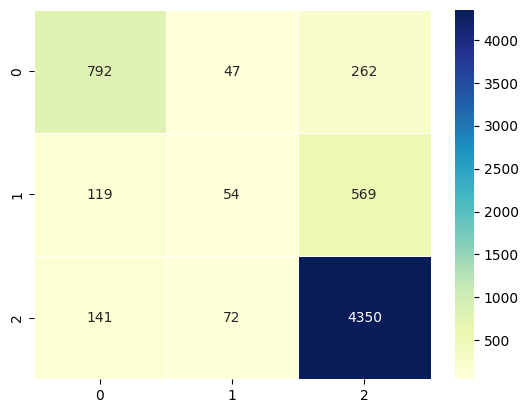

In [12]:
# Evaluate the model with a confusion matrix
cm = confusion_matrix(y_test, y_test_predicted)
sns.heatmap(cm, cmap='YlGnBu', annot=True, fmt='d', linewidths=.5)

ImportError: You must install graphviz to plot tree

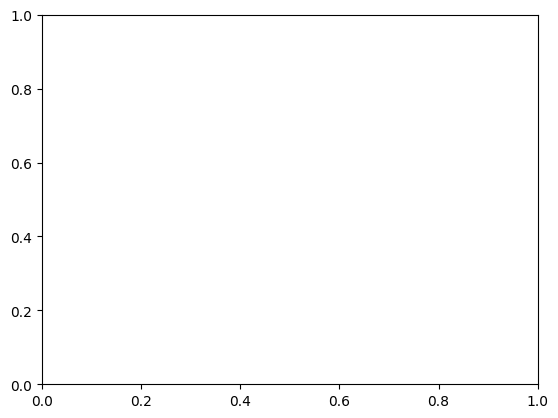

In [14]:
# plot single tree
plot_tree(bst)
plt.show()

In [ ]:
bst.get_params()

{'objective': 'multi:softprob',
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'device': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': None,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'multi_strategy': None,
 'n_estimators': None,
 'n_jobs': -1,
 'num_parallel_tree': None,
 'random_state': 1234,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}

In [ ]:
# Defining parameter space for grid-search. Since we want to access the classifier step (called 'logreg') in our pipeline 
# A parameter grid for XGBoost
params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [1, 2, 3, 4, 5],
        'learning_rate': [0.1, 0.2, 0.5, 1, 2, 5, 10],
        'n_estimators': [1, 10, 100, 1000]
        }

xgb = XGBClassifier(objective='multi:softprob'
                   ) #learning_rate=0.02, silent=True, nthread=1


In [ ]:
folds = 10
param_comb = 5

skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = RSEED)

random_search = RandomizedSearchCV(xgb, 
                                   param_distributions=params, 
                                   n_iter=100, 
                                   scoring='accuracy', # scoring='roc_auc', 'accuracy'
                                   n_jobs=-1, cv=skf.split(X_train,y_train),
                                   verbose=3, 
                                   random_state=RSEED)

# Fit the model
random_search.fit(X_train, y_train)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[CV 7/10] END colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=2, min_child_weight=5, n_estimators=1000, subsample=0.8;, score=0.808 total time=   4.7s
[CV 3/10] END colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=2, min_child_weight=5, n_estimators=1000, subsample=0.8;, score=0.813 total time=   4.7s
[CV 1/10] END colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=2, min_child_weight=5, n_estimators=1000, subsample=0.8;, score=0.821 total time=   4.7s
[CV 4/10] END colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=2, min_child_weight=5, n_estimators=1000, subsample=0.8;, score=0.811 total time=   4.8s
[CV 8/10] END colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=2, min_child_weight=5, n_estimators=1000, subsample=0.8;, score=0.815 total time=   4.8s
[CV 6/10] END colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=2, min_child_weight=5, n_estimators=1000, subsample=0.8;, score=0.825 total time=   4.7s
[CV 2/10] END colsampl

RandomizedSearchCV(cv=<generator object _BaseKFold.split at 0x17718f640>,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           importance_type=No...
                                           num_parallel_tree=None,
                                           objective='multi:softprob', ...),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.6, 0.8, 1.0],
                                        'gamma': [0.5, 1, 1.5, 2, 5],
                                        'learning_rate': [0.1, 0.2, 0.5, 1, 2,
                                                          5, 10],
                                        'max_depth': [1, 2, 3, 4, 5],
                                        'min_child_weight': [1, 5, 10],
                                        'n_estimators': [1, 10, 100, 1000],
                                        'subsample': [0.6, 0.8, 1.0]},
                   random_state=1234, scoring='accuracy', verbose=3)

In [ ]:
print('\n All results:')
print(random_search.cv_results_)
print('\n Best estimator:')
print(random_search.best_estimator_)
print('\n Best normalized gini score for %d-fold search with %d parameter combinations:' % (folds, param_comb))
print(random_search.best_score_ * 2 - 1)
print('\n Best hyperparameters:')
print(random_search.best_params_)


 All results:
{'mean_fit_time': array([4.71533439, 0.45005138, 3.42675879, 0.10613773, 0.05052159,
       0.41982312, 0.55721898, 0.45787814, 0.59625161, 0.42221601,
       0.6373801 , 0.05187042, 0.14007621, 3.08751848, 4.24423645,
       0.07452044, 3.1152168 , 0.48031154, 0.50326793, 0.0505934 ,
       0.67031281, 4.00545802, 0.40373826, 0.0850189 , 0.1261673 ,
       3.56844449, 0.11637924, 0.47927129, 0.04916589, 0.53743052,
       0.09013081, 0.11982567, 0.12547932, 0.38561342, 0.04984088,
       0.05170383, 3.6084635 , 0.1623503 , 0.4915328 , 0.61891928,
       5.68278677, 0.0517226 , 0.16340294, 0.1491442 , 0.09901979,
       0.13281024, 0.07652051, 0.05053599, 0.51432192, 0.04889665,
       0.151156  , 0.06399827, 0.05137458, 0.08689942, 0.04896488,
       0.05313468, 0.05381601, 0.45220535, 0.1221899 , 0.04704792,
       0.05324326, 0.04613965, 0.41168456, 0.61723833, 4.32972507,
       0.58711545, 0.92135463, 3.58208826, 0.05479856, 3.25329926,
       3.07437456, 0.65986252

In [ ]:
# Save best estimator (including fitted preprocessing steps) as best_model 
best_model = random_search.best_estimator_
best_model

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=1, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=10, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [ ]:
# Calculating the accuracy, recall and precision for the test set with the optimized model
y_test_predicted = best_model.predict(X_test)

# Evaluate your model 
print("Accuracy: {:.2f}".format(accuracy_score(y_test, y_test_predicted)))
print("Recall: {:.2f}".format(recall_score(y_test, y_test_predicted, average="weighted")))
print("Precision: {:.2f}".format(precision_score(y_test, y_test_predicted, average="weighted")))

Accuracy: 0.82
Recall: 0.82
Precision: 0.77


In [ ]:
# Evaluate your model
print(classification_report(y_test, y_test_predicted))

              precision    recall  f1-score   support

           0       0.77      0.74      0.75      1101
           1       0.39      0.03      0.06       742
           2       0.83      0.97      0.90      4563

    accuracy                           0.82      6406
   macro avg       0.66      0.58      0.57      6406
weighted avg       0.77      0.82      0.77      6406



ImportError: You must install graphviz to plot tree

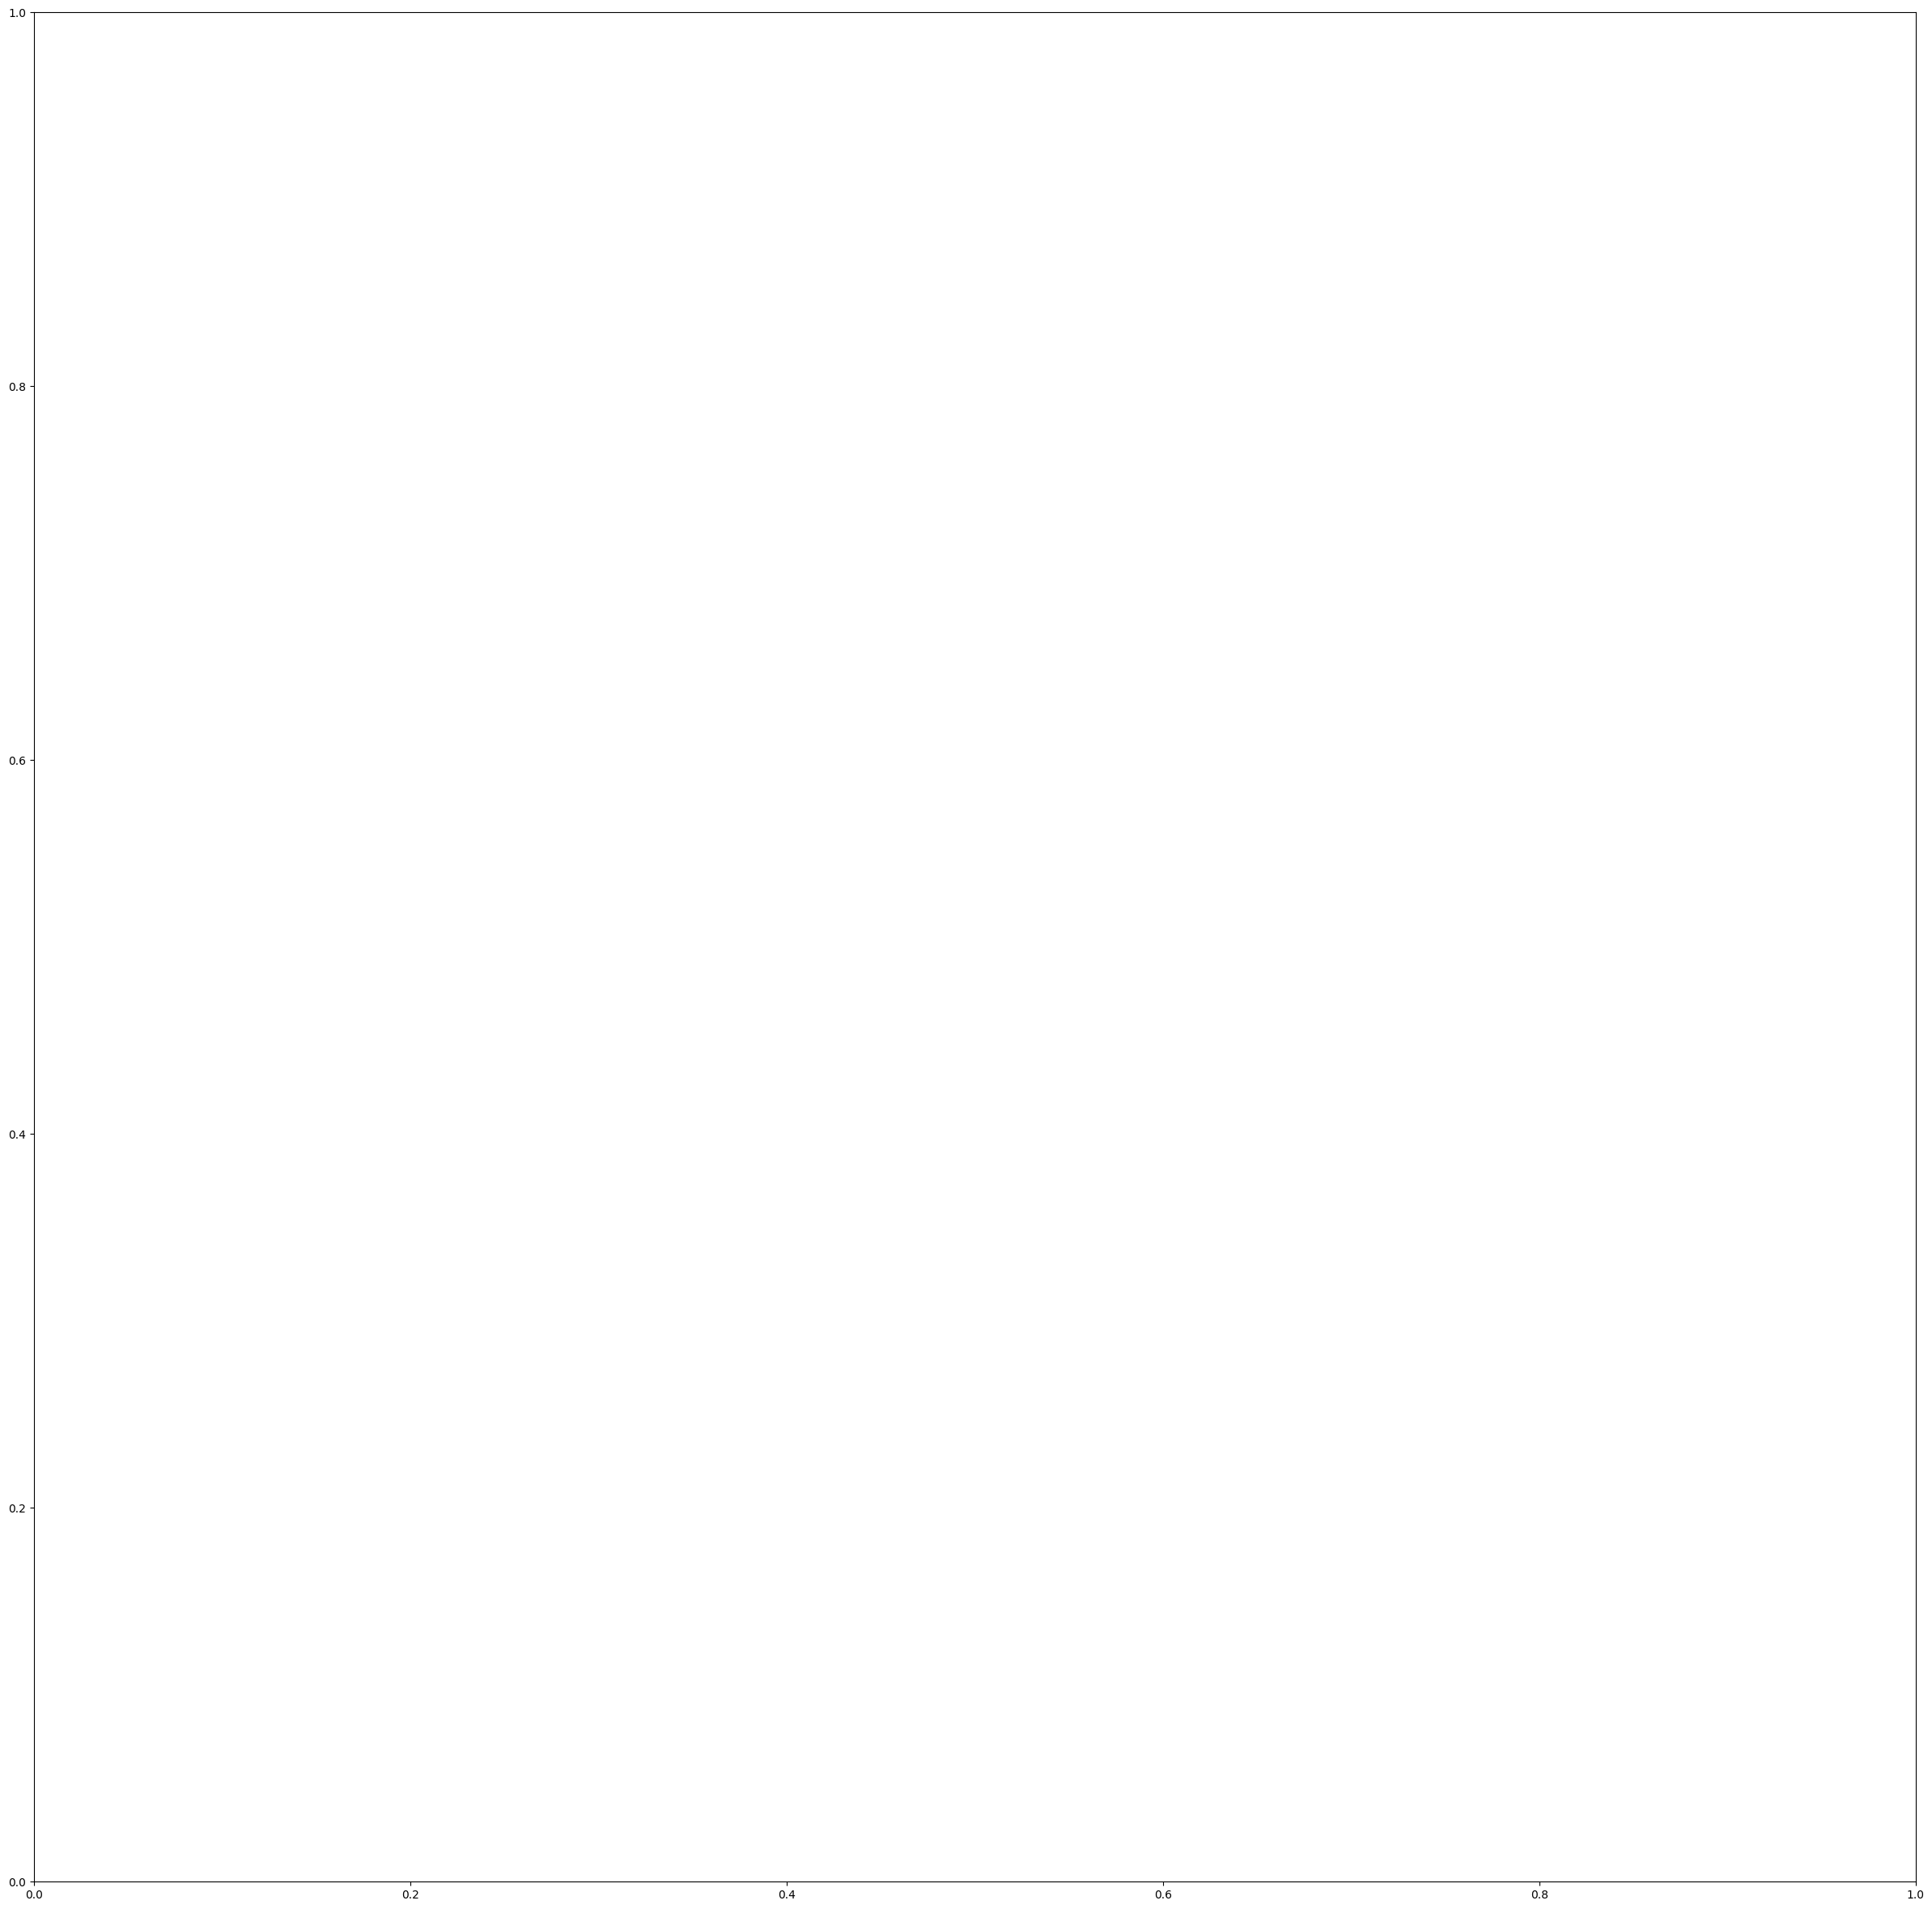

In [ ]:
fig, ax = plt.subplots(figsize=(30, 30))
plot_tree(best_model, num_trees=4, ax=ax)
plt.show()

#plt.savefig("temp.pdf")